In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
from seispy.station import homestake
from scipy.linalg import pinv2,svd
from numpy.linalg import inv
# from numba import jit
plt.style.use('stylesheet.mplstyle')
from scipy.io import savemat
import astropy.units as u
import numpy as np
import os
os.environ['PROJ_LIB'] = '/home/patrick.meyers/anaconda3/envs/meyers/share/proj'
import seispy.plot as hplot
# import ligo.skymap.plot as hplot
import healpy as hp
from seispy.utils import AnisCoefficients_pix as anis
from astropy import units as u
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

In [2]:
 # parameters for injections
amplitude = 1e-4 #UNITS? m? dimensionless? other?
freq = 1 #Hz
tick_font_size=20
duration=500
velocity=5700
fftlength = 5
directions=[[0,90]] # list of (phi,theta) pairs (direction of wave destination with current conventions)
nside = 16
# set up array
stations=homestake(origin='TPK')
?homestake

Signature: homestake(keylist=None, origin=None, coords='depth')
Docstring:
Return a dict with homestake array

Parameters
----------
stationlist : `str`, optional
    list of stations to return in StationArray object. Default
    is to return all stations. Will also return all if 'All' is given.
    Will return surface stations of 'surface' is given.
    Will return underground stations if 'underground' is given.
origin : `str`, optional
    station which will be used as
    origin (None defaults to using first element in array)
File:      ~/git_repos/seismic_radiometer/seispy/station/station.py
Type:      function


In [3]:
data = SeismometerArray.initialize_all_good(stations, duration, chans_type='fast_chans')
Nsims = 1
data.add_p_wave(amplitude / np.sqrt(Nsims), np.radians(-30), np.radians(90),freq,duration=duration, c=velocity, phase_noise_amp=0)
data.add_p_wave(amplitude / np.sqrt(Nsims), np.radians(30), np.radians(120),freq,duration=duration, c=velocity, phase_noise_amp=0)
data.add_white_noise(1e-9)
Ys = data.get_coherences(freq, fft_duration=fftlength) / fftlength**2

2628


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


In [4]:
G_healpy, shapes = data.get_gamma_matrix_healpy('p',stations,velocity,freq, nside=nside)
Fisher = np.dot(G_healpy.conj(), G_healpy.T)
full_inv = inv(Fisher)
u, s, vh = svd(Fisher, full_matrices=False, check_finite=False) # get svd

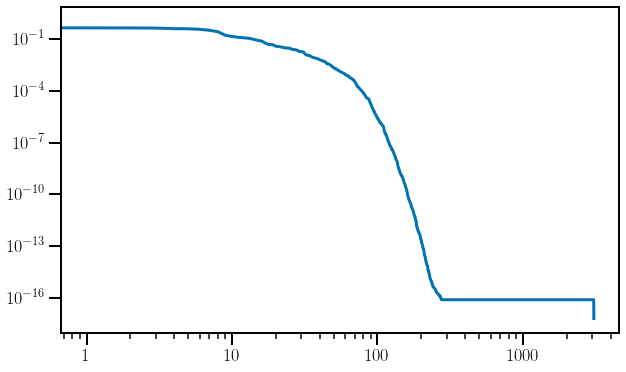

In [5]:
plt.plot(s/np.max(s))
plt.xscale('log')
plt.yscale("log")
plt.show()

In [6]:
def solve(G_healpy, coherences, cond=1e-6, u=None, vh=None, s=None):
    Fisher = np.dot(G_healpy.conj(), G_healpy.T)
    if u is None or vh is None or s is None:
        u, s, vh = svd(Fisher, full_matrices=False, check_finite=False)
    rank = np.sum(s > cond * np.max(s))
    psigma_diag = 1.0 / s[: rank]
    InvFisher = np.transpose(np.conjugate(np.dot(u[:, : rank] *
                                             psigma_diag, vh[: rank])))
    dirty_map = np.dot(G_healpy.conj(), coherences)
    MRM = InvFisher.dot(Fisher)
    return np.real(np.dot(InvFisher, dirty_map)), MRM

In [7]:
def plot_map(ax, mymap, mymin, mymax, contour_val=None, cmap='RdBu_r'):
    hplot.healpix_heatmap(mymap, cmap=cmap, vmin=mymin, vmax=mymax)
    ax.grid(True)
    # plt.title(r'$p$-wave recovery for $r$ and $p$-wave injection',y=1.08, fontsize=30)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size)
    h = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.08)
    if contour_val is not None:
        hplot.healpix_contour(mymap, [contour_val], colors='k', width=20, linestyle='-', rasterized=True, linewidths=2, linestyles='-')
    h.ax.tick_params(labelsize=tick_font_size)
    h.ax.set_xlabel('Power [$\\rm{m^2}$]')
    text = h.ax.xaxis.get_offset_text()
    text.set_size(26)
    # add east, south, and north information.
    ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
    ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
    # ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
    ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)

1.2611579279e-10
2.78375058707e-08


/home/patrick.meyers/anaconda3/envs/seismic_work/lib/python3.9/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/home/patrick.meyers/git_repos/seismic_radiometer/seispy/plot.py:496: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  aximg.cmap.set_bad('w', alpha=0.)
/home/patrick.meyers/git_repos/seismic_radiometer/seispy/plot.py:517: UserWarning: The following kwargs were not used by contour: 'width', 'linestyle', 'rasterized'
  ax = plt.contour(xx, yy, zz, *args, **kwargs)


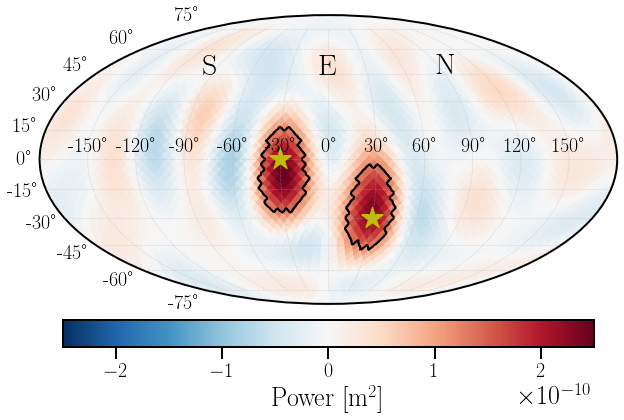

In [8]:
plt.figure(figsize=(12,6))
ax = plt.gca()
mymap, MRM = solve(G_healpy, Ys, cond=1e-3, u=u, vh=vh, s=s)
S = np.real(mymap.copy())
# S = np.real(S_full.copy())
S_sorted = np.sort(S)[::-1]
S_cdf = S_sorted.cumsum() / S_sorted.cumsum()[-1]
contour_val = np.min(S_sorted[S_cdf < 0.90])
print(contour_val)

print(np.sum(mymap))
MRM *= amplitude**2
ax = plt.subplot(111, projection='mollweide')
# ax.set_title('$\\hat{ \\rm{{\\bf P}}}_{\\rm ML}$\\\\$s_{\\rm min}=10^{-10}$', y=1.15)
ax.tick_params(labelsize=tick_font_size)
ax.scatter(np.radians([-30,30]),np.radians([0,-30]), marker='*',s=512, c='y', rasterized=True)
# ax.scatter(np.radians([-30,60]),np.radians([-30,30]), marker='*',s=512, c='y', rasterized=True)
plot_map(ax, mymap, -np.abs(mymap).max(), np.abs(mymap).max(), contour_val=contour_val)
plt.tight_layout()
plt.savefig('p_wave_recovery_two_sources')
plt.savefig('p_wave_recovery_two_sources.pdf')